In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
from methods import IBU, NPU, MADE

import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
tfb = tfp.bijectors

2023-02-13 19:46:36.899548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 19:46:49.694295: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-13 19:46:49.694321: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-13 19:47:32.940152: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [128]:
# Generate data for W0 training (as well as theta)

bins = np.linspace(-5,5,11)
nbins = len(bins)-1

Ndata = 100000
Nsim = 10000000

mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1

mu_data = 0
sigma_data = 1.2
beta_data = 0
epsilon_data = 1

p = np.array([1./nbins for i in range(1, nbins+1)])

# simulation
T_sim = np.random.normal(mu_sim,sigma_sim,Nsim)
R = []
for i in range(1,nbins+1):
    T_sim_i = T_sim[np.digitize(T_sim, bins)==i]
    R_sim_i = np.random.normal(T_sim_i+beta_sim,epsilon_sim)
    ms = np.array([(np.digitize(R_sim_i, bins)==i).sum()/len(T_sim_i) for i in range(1, nbins+1)])
    ms /= ms.sum() # should we normalize the total probablitiy to 1?
    R.append(ms)
R = np.transpose(np.array(R))

# data
T_data = np.random.normal(mu_data,sigma_data,Ndata).reshape(-1, 1)
R_data = np.random.normal(T_data+beta_data,epsilon_data)
t = np.array([(np.digitize(T_data, bins)==i).sum() for i in range(1, nbins+1)])
m = np.array([(np.digitize(R_data, bins)==i).sum() for i in range(1, nbins+1)])

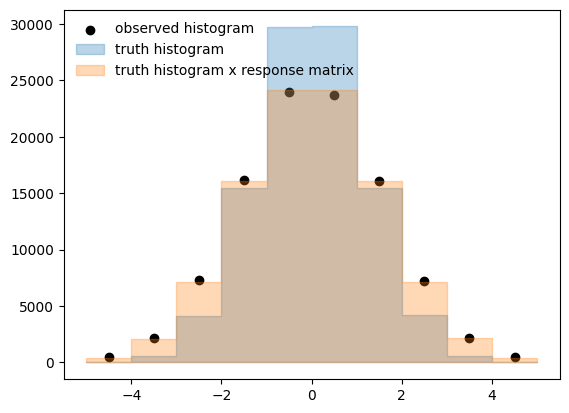

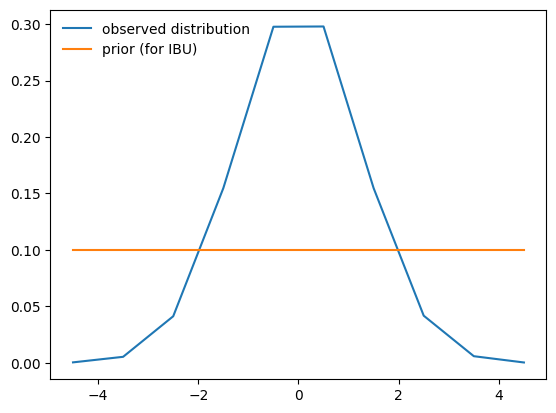

In [129]:
plt.scatter(0.5*(bins[1:]+bins[:-1]), m, color='black', label='observed histogram')
plt.fill_between(bins, np.insert(t, len(t), np.array(t[-1])), step='post', alpha=0.3, color='tab:blue', label='truth histogram')
plt.fill_between(bins, np.insert(np.matmul(R, t), len(np.matmul(R, t)), np.array(np.matmul(R, t)[-1])), step='post', alpha=0.3, color='tab:orange', label='truth histogram x response matrix')
plt.legend(frameon=False, loc="upper left")
plt.show()
plt.clf()

plt.plot(0.5*(bins[1:]+bins[:-1]), t/t.sum(), label='observed distribution')
plt.plot(0.5*(bins[1:]+bins[:-1]), p, label='prior (for IBU)')
plt.legend(frameon=False, loc="upper left")
plt.show()

In [136]:
def MLE(model,ymes,ndim):
    x = tf.Variable(ndim*[1.0/ndim])
    loss = lambda: -model.log_prob(x, bijector_kwargs={'conditional_input': ymes})
    losses = tfp.math.minimize(loss,
                               num_steps=200,
                               #convergence_criterion=(
                               #     tfp.optimizers.convergence_criteria.LossNotDecreasing(atol=0.001)),
                               trainable_variables=[x],
                               optimizer=tf.optimizers.Adam(learning_rate=0.01))
    return x

def MADE(data_shape, cond_shape):
    # Density estimation with MADE.
    made = tfb.AutoregressiveNetwork(params=2,
                                     hidden_units=[16,16], #To be changed when using bigger histograms
                                     event_shape=data_shape,
                                     activation='swish',
                                     conditional=True,
                                     conditional_event_shape=cond_shape,
                                    )
    distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[data_shape]),
        bijector=tfb.MaskedAutoregressiveFlow(made))

    # Construct and fit model.
    x_ = tfkl.Input(shape=(data_shape,), dtype=tf.float32)
    c_ = tfkl.Input(shape=(cond_shape,), dtype=tf.float32)
    log_prob_ = distribution.log_prob(x_, bijector_kwargs={'conditional_input': c_})
    model = tfk.Model([x_,c_], log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-2),loss=lambda _, log_prob: -log_prob)
    return model, distribution

def NPU(ymes,Rin,N):
    #Inputs: 
    # ymes: Measured data provided in a histogram with M bins (M,)
    # Rin: Detector resolution matrix. First coordinate is the measured value and second coordinate is the truth level. (M,M)
    # N: Total number of observations
    #Returns samples from p(true|measured).  Would normally want the mode over true, which is equivalent to the MLE given p(true) is uniform.

    M = 1000000 # a big number - should make bigger later
    nsample = 1000
#     ts = np.random.dirichlet(np.ones(len(ymes)),size=M)*N
    ts = np.random.uniform(0,1,(M,len(ymes))) #M values with B bins
    ts=ts/np.sum(ts,-1,keepdims=True)*N

    ms = []
    for j in range(len(ts)):
        if j % 100000 == 0: print(f"{j}/{len(ts)}")
        m_hold = [np.random.poisson(ts[j][i]) for i in range(len(ts[j]))] #stat fluctuations
        m_holds = np.random.multinomial(m_hold[0],Rin[:,0])
        for i in range(1, len(ts[j])):
            m_holds += np.random.multinomial(m_hold[i],Rin[:,i])
        ms += [m_holds]
        pass
    ts = np.array(ts)
    ms = np.array(ms)

    n = len(ts)
    x = ms #conditional feature
    y = ts #learn p(y|x)
    nx = N
    ny = N

    #Normalize the total number of events to make the NF easier to train
    x = x/float(nx)
    y = y/float(ny)

    model,dist = MADE(y.shape[1],x.shape[1])
    # Fit.
    batch_size = 100
    myhistory = model.fit([y,x],
                          y=np.zeros((len(x),0), dtype=np.float32), #dummy labels
                          batch_size=batch_size,
                          epochs=50,
                          verbose = 1)

    #plt.plot(myhistory.history['loss'][10:-1])
    #plt.xlabel("epochs")
    #plt.ylabel("loss")

    #mle = MLE(dist,ymes/float(nx),y.shape[-1])
    #print(mle)
    mle = MLE(dist,ymes/float(nx),y.shape[-1]).numpy()
    output = dist.sample(nsample, bijector_kwargs={'conditional_input': np.tile(ymes/float(nx),nsample).reshape([nsample,len(ymes)])}).numpy()
    return output*ny,mle*ny

In [137]:
N = m.sum()
print(N)

npu,mle = NPU(m,R,N)

99855
0/1000000
100000/1000000
200000/1000000
300000/1000000
400000/1000000
500000/1000000
600000/1000000
700000/1000000
800000/1000000
900000/1000000
Epoch 1/50
10000/10000 [==============================] - 10s 922us/step - loss: -30.0869
Epoch 2/50
10000/10000 [==============================] - 9s 926us/step - loss: -35.6494
Epoch 3/50
10000/10000 [==============================] - 9s 947us/step - loss: -36.7329
Epoch 4/50
10000/10000 [==============================] - 10s 954us/step - loss: -37.1514
Epoch 5/50
10000/10000 [==============================] - 9s 950us/step - loss: -37.2675
Epoch 6/50
10000/10000 [==============================] - 9s 941us/step - loss: -37.4719
Epoch 7/50
10000/10000 [==============================] - 9s 940us/step - loss: -37.5866
Epoch 8/50
10000/10000 [==============================] - 9s 935us/step - loss: -37.5816
Epoch 9/50
10000/10000 [==============================] - 9s 896us/step - loss: -37.7374
Epoch 10/50
10000/10000 [=====================

In [139]:
npu.reshape(-1)
# np.array(list(range(nbins))*1000).shape
mle
# npu

array([ -200.70391723,  2314.06850341,   856.3435643 , 19341.99837774,
       28233.69280279, 28189.34280261, 14310.3014414 ,  8671.65854886,
       -3312.46708162,  1447.84928578])

In [132]:
ibu = IBU(m,p,R,10)

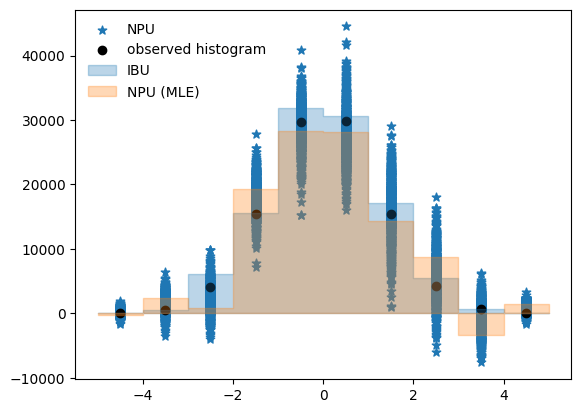

<Figure size 640x480 with 0 Axes>

In [149]:
# plt.scatter(np.array(list(range(nbins))*1000),npu.reshape(-1), marker='*', label="True",s=500)
# plt.plot(range(nbins), t, label='observed histogram')
# plt.plot(range(nbins), ibu)
# plt.plot(range(nbins), mle)

plt.scatter(list(0.5*(bins[1:]+bins[:-1]))*1000,npu.reshape(-1), marker='*', label="NPU",s=40)
plt.scatter(0.5*(bins[1:]+bins[:-1]), t, color='black', label='observed histogram')
plt.fill_between(bins, np.insert(ibu, len(ibu), np.array(ibu[-1])), step='post', alpha=0.3, color='tab:blue', label='IBU')
plt.fill_between(bins, np.insert(mle, len(mle), np.array(mle[-1])), step='post', alpha=0.3, color='tab:orange', label='NPU (MLE)')
plt.legend(frameon=False, loc="upper left")
plt.show()
plt.clf()